<h1 style="
    font-size: 42px;
    font-family: 'Segoe UI', sans-serif;
    font-weight: bold;
    color: #6a0dad;
    text-align: center;
    background-color: #e6f0fa;
    border-radius: 10px;
    padding: 20px;
    box-shadow: 2px 2px 8px rgba(0,0,0,0.1);
">
    Twitter Sentiment Analysis — LSD_B1_Project
</h1>


 [Link to data](https://www.kaggle.com/code/paoloripamonti/twitter-sentiment-analysis/data)

<h1 style="color:blue;">Step 1: Import Libraries</h1>
<p>Import all required Python libraries for data loading, preprocessing, modeling, and visualization.</p>



In [ ]:

# Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import TfidfVectorizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from nltk.corpus import stopwords
from gensim.models import Word2Vec
from sklearn.ensemble import RandomForestClassifier




<h1 style="color:blue;">Step 2: Download Stopwords</h1>
<p>Download the English stopword list using NLTK. These words will be removed from tweets to reduce noise.</p>



In [ ]:

# Download stopwords
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\kerry/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
print(stopwords.words('english'))

['a', 'about', 'above', 'after', 'again', 'against', 'ain', 'all', 'am', 'an', 'and', 'any', 'are', 'aren', "aren't", 'as', 'at', 'be', 'because', 'been', 'before', 'being', 'below', 'between', 'both', 'but', 'by', 'can', 'couldn', "couldn't", 'd', 'did', 'didn', "didn't", 'do', 'does', 'doesn', "doesn't", 'doing', 'don', "don't", 'down', 'during', 'each', 'few', 'for', 'from', 'further', 'had', 'hadn', "hadn't", 'has', 'hasn', "hasn't", 'have', 'haven', "haven't", 'having', 'he', "he'd", "he'll", 'her', 'here', 'hers', 'herself', "he's", 'him', 'himself', 'his', 'how', 'i', "i'd", 'if', "i'll", "i'm", 'in', 'into', 'is', 'isn', "isn't", 'it', "it'd", "it'll", "it's", 'its', 'itself', "i've", 'just', 'll', 'm', 'ma', 'me', 'mightn', "mightn't", 'more', 'most', 'mustn', "mustn't", 'my', 'myself', 'needn', "needn't", 'no', 'nor', 'not', 'now', 'o', 'of', 'off', 'on', 'once', 'only', 'or', 'other', 'our', 'ours', 'ourselves', 'out', 'over', 'own', 're', 's', 'same', 'shan', "shan't", 'she

<h1 style="color:blue;">Step 3: Load and Clean Tweet Data </h1>
<p>
Loaded the full dataset (1.6 million tweets) and selected only useful columns for sentiment classification.<br>
Cleaned the text by:
</p>
<ul>
  <li>Converting to lowercase</li>
  <li>Removing URLs, symbols, and special characters</li>
  <li>Removing stopwords</li>
</ul>
<p>
Also checked for missing values (none found) and verified that labels are balanced between positive (1) and negative (0).
</p>



In [ ]:

# Load Data
data = pd.read_csv("C:/Users/kerry/OneDrive/桌面/training.1600000.processed.noemoticon.csv", encoding='latin-1', header=None)
data.columns = ['target', 'ids', 'date', 'flag', 'user', 'text']
data = data[data['target'].isin([0, 4])]
data['target'] = data['target'].apply(lambda x: 0 if x == 0 else 1)
print("Data shape after loading:", data.shape)


Data shape after loading: (1600000, 6)


In [ ]:
data.head()

,target,ids,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [ ]:
#checking for missing values
data.isnull().sum()

target    0
ids       0
date      0
flag      0
user      0
text      0
dtype: int64

In [ ]:
# Distribution of tweets
data['target'].value_counts()

target
0    800000
1    800000
Name: count, dtype: int64

In [ ]:
# Step 4: Clean Text
def clean_text(text):
    text = text.lower()
    text = re.sub(r"http\S+", "", text)
    text = re.sub(r"[^a-z\s]", "", text)
    text = " ".join([word for word in text.split() if word not in stop_words])
    return text

data['clean_text'] = data['text'].apply(clean_text)
print("Sample cleaned texts:")
print(data['clean_text'].head())


Sample cleaned texts:
0    switchfoot awww thats bummer shoulda got david...
1    upset cant update facebook texting might cry r...
2    kenichan dived many times ball managed save re...
3                     whole body feels itchy like fire
4             nationwideclass behaving im mad cant see
Name: clean_text, dtype: object


<h1 style="color:blue;">Step 4: Text processing Methods (Jiayi)</h1>
<p>Transform the cleaned tweets into numeric vectors so they can be fed into machine learning models.</p>

<h4 style="color:blue;">TF-IDF Vectorization</h4>
<p>Use TF-IDF to convert tweets into vectors. This method gives more importance to words that are unique within a tweet but not too common across the dataset. We sample 50,000 rows and use 3,000 top features.</p>

In [ ]:

# Step 5: TF-IDF Vectorization
sample_size = 50000
data = data.sample(frac=1, random_state=42).reset_index(drop=True)
data = data.iloc[:sample_size]

vectorizer = TfidfVectorizer(max_features=3000)
X_tfidf = vectorizer.fit_transform(data['clean_text']).toarray()
y = data['target'].values
print("TF-IDF feature matrix shape:", X_tfidf.shape)


TF-IDF feature matrix shape: (50000, 3000)


<h4 style="color:blue;">TF-IDF Weighted Word2Vec</h4>
<p>Use pre-trained Word2Vec embeddings and apply TF-IDF weights for better word importance. Steps:</p> <ul> <li>Tokenize each tweet.</li> <li>Train Word2Vec on these tokens.</li> <li>Compute a TF-IDF weight for each word.</li> <li>For each tweet, calculate a weighted average of word vectors using TF-IDF.</li> </ul> <p>This gives a more meaningful representation by combining local context (Word2Vec) with word importance (TF-IDF).</p>

In [ ]:
from gensim.models import Word2Vec
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np

# Step 1: Tokenize cleaned text
data['tokens'] = data['clean_text'].apply(lambda x: x.split())

# Step 2: Train Word2Vec model
w2v_model = Word2Vec(sentences=data['tokens'], vector_size=100, window=5, min_count=5, workers=4)

# Step 3: Fit TF-IDF on clean text
tfidf = TfidfVectorizer()
tfidf.fit(data['clean_text'])

# Step 4: Build a dict: word -> idf weight
idf_dict = dict(zip(tfidf.get_feature_names_out(), tfidf.idf_))

# Step 5: TF-IDF weighted average Word2Vec function
def get_weighted_w2v(tokens, model, idf_weights, dim=100):
    weighted_vecs = []
    for word in tokens:
        if word in model.wv and word in idf_weights:
            weight = idf_weights[word]
            weighted_vecs.append(model.wv[word] * weight)
    if weighted_vecs:
        return np.mean(weighted_vecs, axis=0)
    else:
        return np.zeros(dim)

# Step 6: Apply to all samples
X_w2v_weighted = np.vstack(data['tokens'].apply(lambda x: get_weighted_w2v(x, w2v_model, idf_dict)))

print("TF-IDF Weighted Word2Vec shape:", X_w2v_weighted.shape)


TF-IDF Weighted Word2Vec shape: (50000, 100)


<h1 style="color:blue;">Step 5: PCA Dimensionality Reduction (Jiayi)</h1>


<h3 style="color: blue;">PCA-based Dimensionality Reduction</h3>

<p>
Following the LST8AutoEncodersDense.ipynb‘s approach (e.g., <code>PCA(n_components=0.95)</code>), dimensionality was reduced by projecting the original feature matrix onto the top <i>k</i> right singular vectors such that 95% of the variance is retained.
</p>

<ul>
  <li>This is consistent with how PCA was applied in class for MNIST digits, but here extended to high-dimensional text data (TF-IDF and Word2Vec).</li>
    
  <li>
PCA not only reduces dimensionality, but also enables anomaly detection. Although not applied in this project, the reconstruction error based on top principal components could be used to identify outliers — as discussed in lecture.


<h2 style="color:blue;">TF-IDF</h2>
<p>Apply PCA to TF-IDF features to reduce dimensionality while keeping 95% of the variance. This balances information retention and efficiency.</p>


PCA-reduced matrix shape: (50000, 2334)


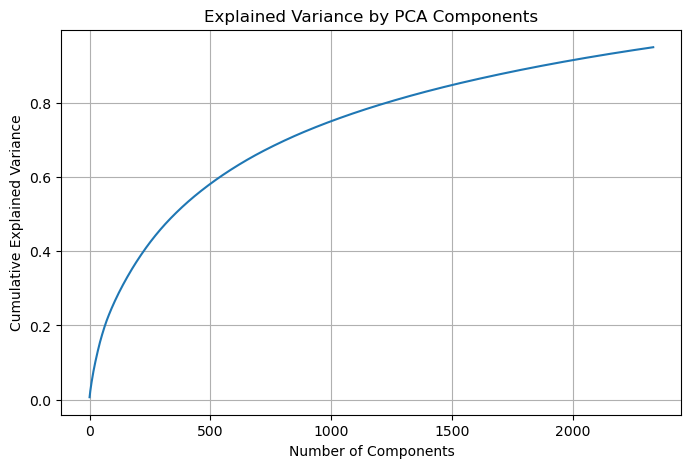

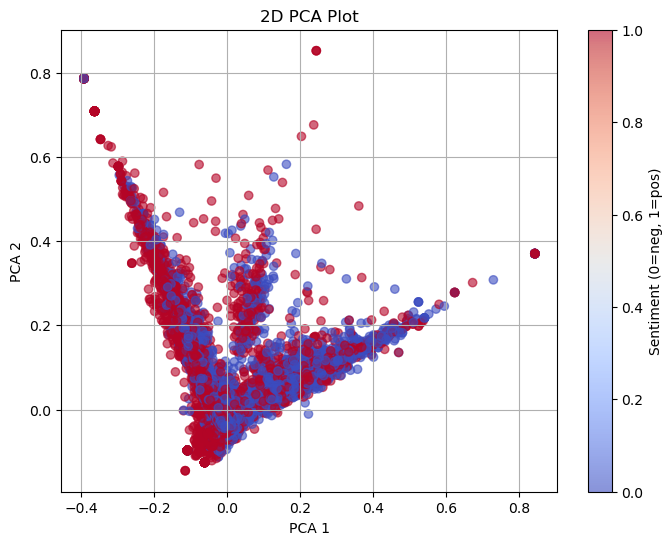

In [ ]:

pca = PCA(n_components=0.95)
X_pca = pca.fit_transform(X_tfidf)
print("PCA-reduced matrix shape:", X_pca.shape)


plt.figure(figsize=(8,5))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance by PCA Components')
plt.grid(True)
plt.show()

plt.figure(figsize=(8,6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap='coolwarm', alpha=0.6)
plt.colorbar(label='Sentiment (0=neg, 1=pos)')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.title('2D PCA Plot')
plt.grid(True)
plt.show()


<h2 style="color:blue;">Word2Vec</h2>
<p>Apply PCA to the Word2Vec feature matrix (weighted by TF-IDF) to reduce dimensions. This simplifies the input while preserving key variation in meaning.</p>


PCA-reduced Word2Vec matrix shape: (50000, 11)


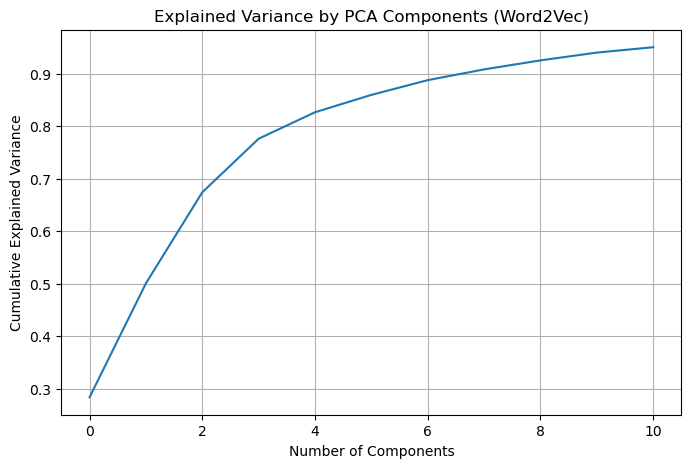

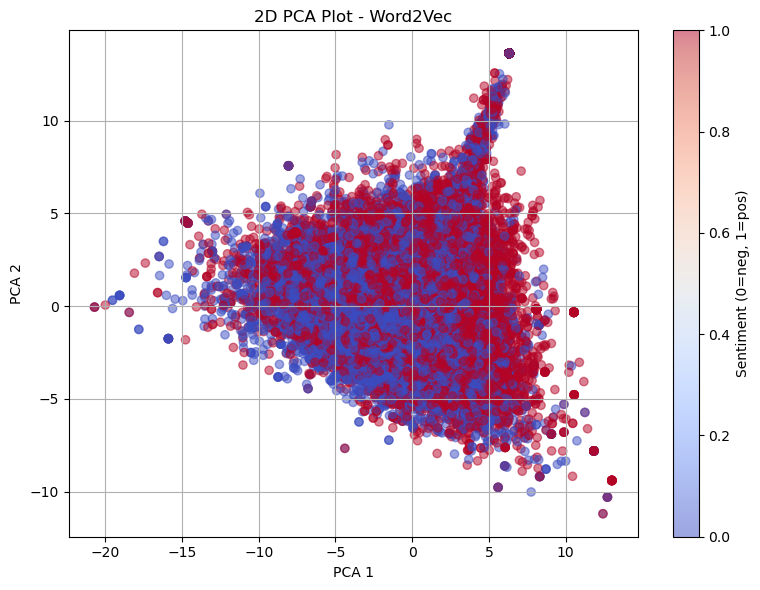

In [ ]:
# PCA on TF-IDF Weighted Word2Vec (retain 95% explained variance)
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca_w2v = PCA(n_components=0.95)
X_w2v_pca = pca_w2v.fit_transform(X_w2v_weighted)
print("PCA-reduced Word2Vec matrix shape:", X_w2v_pca.shape)

plt.figure(figsize=(8,5))
plt.plot(np.cumsum(pca_w2v.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance by PCA Components (Word2Vec)')
plt.grid(True)
plt.show()

pca_vis = PCA(n_components=2)
X_w2v_2d = pca_vis.fit_transform(X_w2v_weighted)

plt.figure(figsize=(8, 6))
scatter = plt.scatter(X_w2v_2d[:, 0], X_w2v_2d[:, 1], c=y, cmap='coolwarm', alpha=0.5)
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.title('2D PCA Plot - Word2Vec')
cbar = plt.colorbar(scatter)
cbar.set_label('Sentiment (0=neg, 1=pos)')
plt.grid(True)
plt.tight_layout()
plt.show()


<b><span style="color:green">
The PCA on Word2Vec showed that 95% of the variance could be captured with just 11 components, meaning the data is already compact. But in the 2D PCA plot, the points were more scattered and overlapped a lot between positive and negative classes. So although Word2Vec is dense and efficient, the sentiment labels didn’t cluster clearly — making it harder to analyze sentiment directly from the PCA space. So later I tried a DNN to see if a deeper model could better capture the separation.
</span>
</b>




<h1 style="color:blue;">Step 6: Train/Test Split (Jiayi)</h1>
<p>Split the reduced dataset into training and testing sets, stratifying to maintain balanced labels.</p>

<ul>
  <li>Used <code>train_test_split()</code> on the PCA-reduced features.</li>
  <li><strong>Stratify=y</strong> ensures class distribution remains balanced (i.e., same ratio of pos/neg in train and test).</li>
  <li>Resulting shapes confirm: <strong>40,000 training</strong> and <strong>10,000 testing</strong> samples from 50,000 total.</li>
</ul>


In [ ]:

# Step 7: Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=42, stratify=y)
print("Train shape:", X_train.shape, "| Test shape:", X_test.shape)


Train shape: (40000, 2334) | Test shape: (10000, 2334)


In [ ]:
print(X_train)

[[ 0.00169869 -0.03846593 -0.03854428 ...  0.00441154  0.00513094
  -0.002674  ]
 [-0.00973377 -0.02795218  0.00988189 ...  0.01003282  0.01077453
  -0.00395276]
 [-0.00632433 -0.03149282 -0.00663885 ...  0.00402207  0.00670996
  -0.01092827]
 ...
 [-0.02482983 -0.0243957   0.00477125 ...  0.00462634  0.01094187
  -0.00039226]
 [ 0.17609474  0.05965676  0.03973094 ... -0.00509884 -0.00111509
   0.00190965]
 [-0.01528208 -0.02149057  0.00729624 ... -0.00258448  0.00035551
   0.00245145]]


<h2><strong>3D PCA of TF-IDF Embeddings</strong></h2>
<p>This 3D scatter plot visualizes tweet distribution after PCA on TF-IDF features.</p>

<ul>
  <li>Used <code>PCA(n_components=3)</code> to project high-dimensional TF-IDF vectors into 3D.</li>
  <li>Color indicates sentiment: <span style="color:red;"><strong>Red = Positive</strong></span>, <span style="color:blue;"><strong>Blue = Negative</strong></span>.</li>
  <li>Visible clustering patterns suggest some separation between sentiment classes, but still with overlap.</li>
</ul>


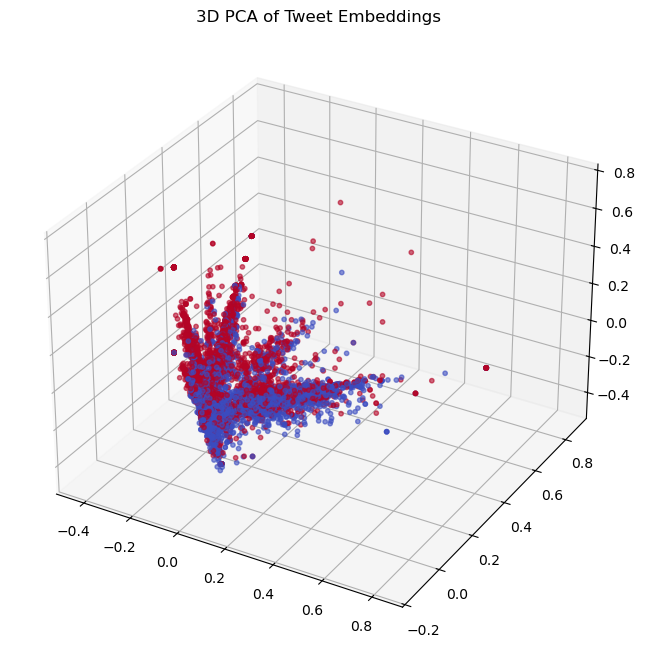

In [ ]:
from mpl_toolkits.mplot3d import Axes3D

pca_3d = PCA(n_components=3)
X_pca_3d = pca_3d.fit_transform(X_train)

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_pca_3d[:, 0], X_pca_3d[:, 1], X_pca_3d[:, 2], c=y_train, cmap='coolwarm', s=10, alpha=0.6)
ax.set_title('3D PCA of Tweet Embeddings')
plt.show()


<h2><strong>3D PCA of Word2Vec Embeddings</strong></h2>
<p>This plot shows tweet embeddings using Word2Vec vectors weighted by TF-IDF, then reduced to 3D via PCA.</p>

<ul>
  <li>Used the weighted average of Word2Vec + TF-IDF to generate dense semantic representations.</li>
  <li><code>PCA(n_components=3)</code> applied for visualization.</li>
  <li>Compared to TF-IDF, this plot is more isotropic and compact, capturing richer word semantics but less visual class separation.</li>
</ul>


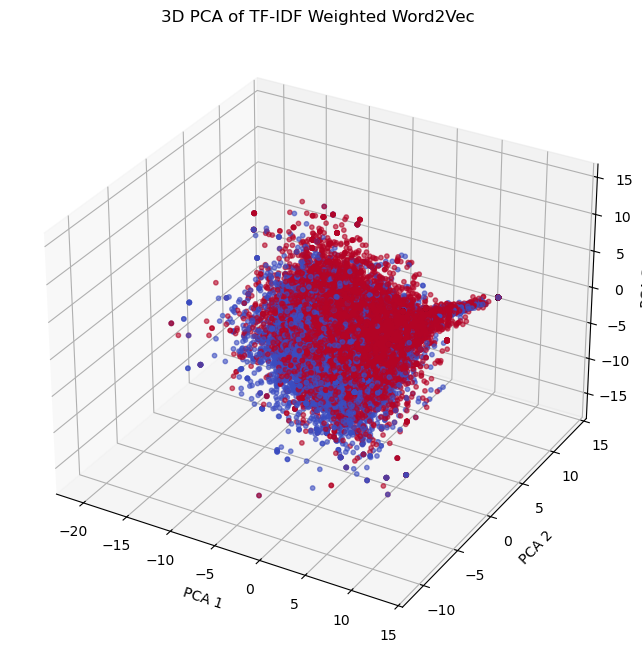

In [ ]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

pca_3d_w2v = PCA(n_components=3)
X_w2v_pca3d = pca_3d_w2v.fit_transform(X_w2v_weighted)

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(X_w2v_pca3d[:, 0], X_w2v_pca3d[:, 1], X_w2v_pca3d[:, 2],
                     c=y, cmap='coolwarm', s=10, alpha=0.6)

ax.set_title('3D PCA of TF-IDF Weighted Word2Vec')
ax.set_xlabel('PCA 1')
ax.set_ylabel('PCA 2')
ax.set_zlabel('PCA 3')
plt.show()


<h1 style="color:darkOrange;">Classification Models: Section A - D </h1>


<h1 style="color:blue;">Section A - Naive Bayes & k-Nearest Neighbors (Erick)</h1>

Please implement **both Naive Bayes and k-NN classifiers** using the PCA-transformed features (`X_pca`).  
You may test different values of `k` for k-NN.

**Required outputs:**
- Classification report for both models
- Confusion matrix for both models
- (Optional) A graph showing performance vs. different `k` values

<h3 style="color:blue;"> Naive Bayes (Erick) </h3>

=== Naive Bayes Classification Report ===
              precision    recall  f1-score   support

           0       0.64      0.61      0.62      4997
           1       0.63      0.66      0.64      5003

    accuracy                           0.63     10000
   macro avg       0.63      0.63      0.63     10000
weighted avg       0.63      0.63      0.63     10000



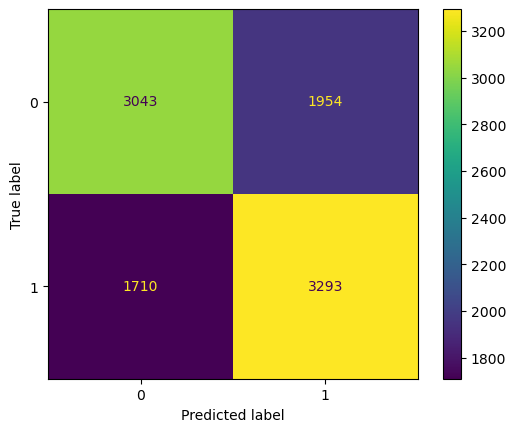

In [ ]:
# Naive Bayes implementation here

from sklearn.naive_bayes import GaussianNB
X_train, X_test, y_train, y_test = train_test_split(
    X_pca, y, test_size=0.2, random_state=42, stratify=y
)

# Train Gaussian Naive Bayes model
nb_model = GaussianNB()
nb_model.fit(X_train, y_train)

# Predict and evaluate
y_pred_nb = nb_model.predict(X_test)

print("=== Naive Bayes Classification Report ===")
print(classification_report(y_test, y_pred_nb))

ConfusionMatrixDisplay.from_predictions(y_test, y_pred_nb)

<h3 style="color:blue;">k-Nearest Neighbors (Erick)</h3>

k=1, Accuracy=0.6065
k=2, Accuracy=0.6091
k=3, Accuracy=0.6151
k=4, Accuracy=0.6130
k=5, Accuracy=0.6114
k=6, Accuracy=0.6157
k=7, Accuracy=0.6070
k=8, Accuracy=0.6131
k=9, Accuracy=0.6039
k=10, Accuracy=0.6049


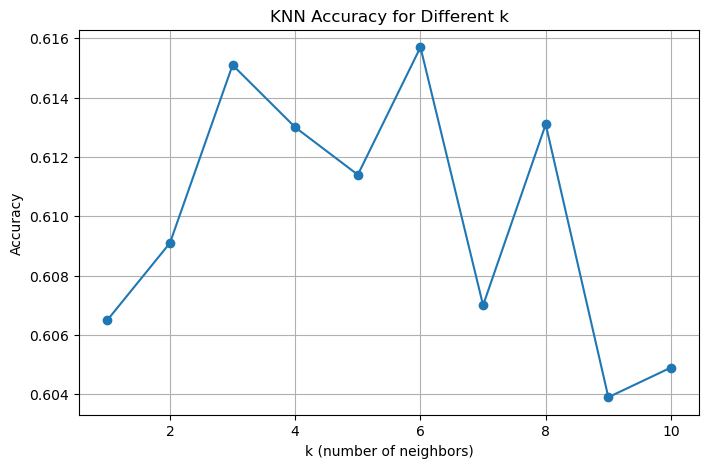


=== KNN Classification Report (k=5) ===
              precision    recall  f1-score   support

           0       0.66      0.45      0.54      4997
           1       0.59      0.77      0.66      5003

    accuracy                           0.61     10000
   macro avg       0.62      0.61      0.60     10000
weighted avg       0.62      0.61      0.60     10000



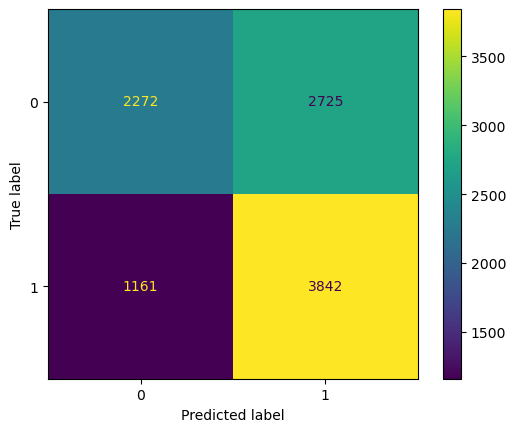

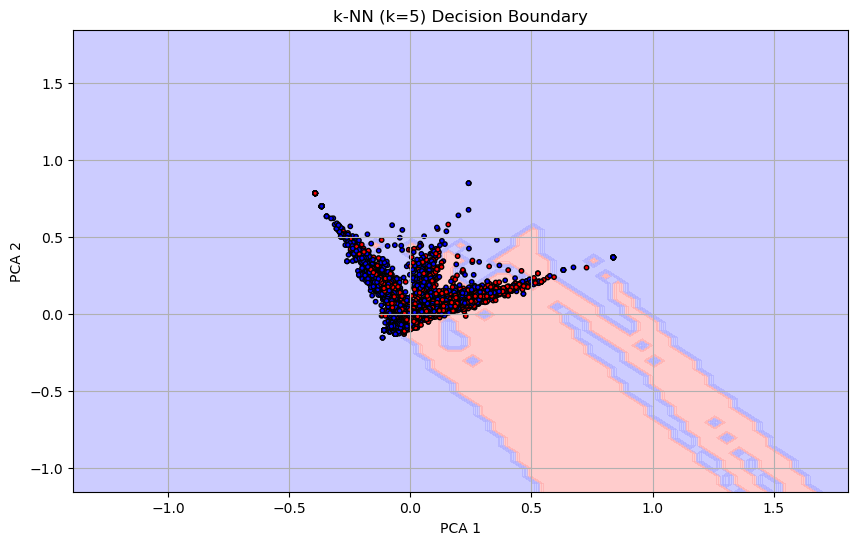

In [ ]:
# K-Nearest Neighbors implementation here

from sklearn.neighbors import KNeighborsClassifier

# Step 1: Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X_pca, y, test_size=0.2, random_state=42, stratify=y
)

# Step 2: Try different k values and track accuracy
k_values = range(1, 11)
accuracies = []

for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    acc = knn.score(X_test, y_test)
    accuracies.append(acc)
    print(f"k={k}, Accuracy={acc:.4f}")

# Step 3: Plot accuracy vs k
plt.figure(figsize=(8, 5))
plt.plot(k_values, accuracies, marker='o')
plt.title("KNN Accuracy for Different k")
plt.xlabel("k (number of neighbors)")
plt.ylabel("Accuracy")
plt.grid(True)
plt.show()

# Step 4: Final model with best k (e.g., k=5)
best_k = 5
knn = KNeighborsClassifier(n_neighbors=best_k)
knn.fit(X_train, y_train)
y_pred_knn = knn.predict(X_test)

# Step 5: Evaluate
print(f"\n=== KNN Classification Report (k={best_k}) ===")
print(classification_report(y_test, y_pred_knn))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_knn)



from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from matplotlib.colors import ListedColormap

# Reduce to 2 PCA dimensions for plotting
pca_2d = PCA(n_components=2)
X_2d = pca_2d.fit_transform(X_tfidf)  # or X_pca if already done

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X_2d, y, test_size=0.2, random_state=42, stratify=y)

# Train KNN
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)

# Plot decision boundary
h = .05  # step size in the mesh
x_min, x_max = X_2d[:, 0].min() - 1, X_2d[:, 0].max() + 1
y_min, y_max = X_2d[:, 1].min() - 1, X_2d[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
Z = knn.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.figure(figsize=(10, 6))
cmap_light = ListedColormap(['#FFAAAA', '#AAAAFF'])
cmap_bold = ListedColormap(['#FF0000', '#0000FF'])

plt.contourf(xx, yy, Z, cmap=cmap_light, alpha=0.6)
plt.scatter(X_2d[:, 0], X_2d[:, 1], c=y, cmap=cmap_bold, edgecolor='k', s=10)
plt.title("k-NN (k=5) Decision Boundary")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.grid(True)
plt.show()



<h1 style="color:blue;">Section B - Decision Tree & Random Forest (Nova)</h1>

Please implement both Decision Tree and Random Forest models using the PCA-transformed features.

**Required outputs:**
- Accuracy and F1 scores
- Feature importance plot (for trees)
- Confusion matrix


<h3 style="color:blue;"> Decision Tree (Nova) </h3>


=== Decision Tree Results
Accuracy: 0.6331
F1 Score: 0.6363

Classification Report:
               precision    recall  f1-score   support

           0       0.64      0.62      0.63      4997
           1       0.63      0.64      0.64      5003

    accuracy                           0.63     10000
   macro avg       0.63      0.63      0.63     10000
weighted avg       0.63      0.63      0.63     10000



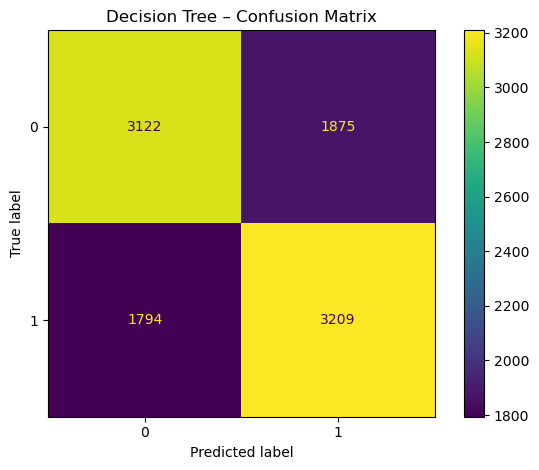

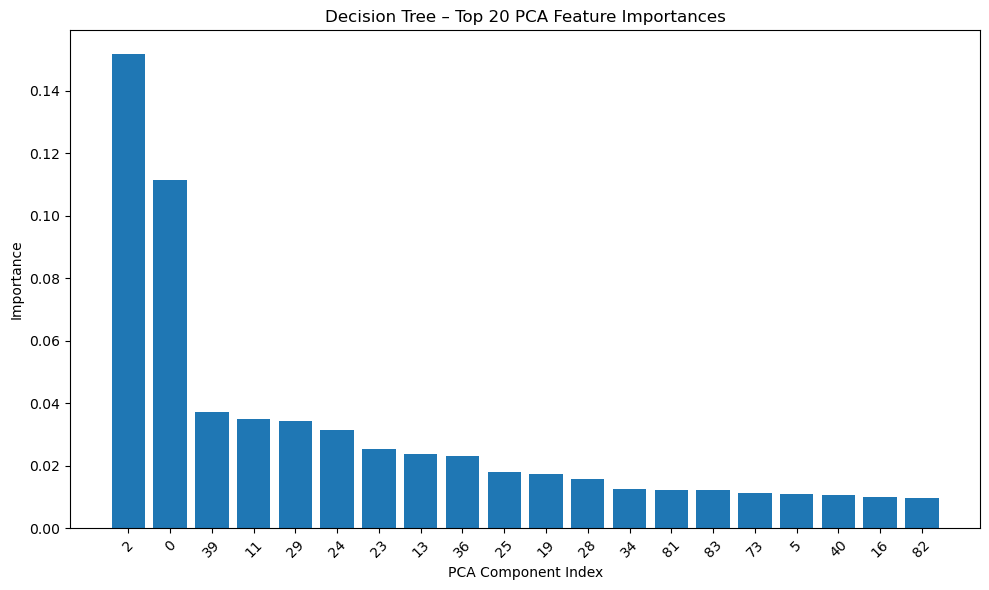

In [ ]:
#Decision Tree Implementation
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    classification_report,
    ConfusionMatrixDisplay
)
import matplotlib.pyplot as plt
import numpy as np

# 1) PCA reduction to 100 components
pca = PCA(n_components=100, random_state=42)
X_pca = pca.fit_transform(X_tfidf)

# 2) Split train/test into training (80%) and testing (20%) sets with balanced
#class distribution. Data is also cast to float32 for faster processing.
X_train, X_test, y_train, y_test = train_test_split(
    X_pca, y, test_size=0.2, random_state=42, stratify=y
)

# 3) Downcast to float32 for speed
X_train = X_train.astype(np.float32)
X_test  = X_test.astype(np.float32)

# 4) Train Decision Tree with leaf constraint with a max depth of 10
#and minimum 5 samples per leaf to avoid overfitting and control complexity.
dt = DecisionTreeClassifier(
    max_depth=10,
    min_samples_leaf=5,
    random_state=42
)
dt.fit(X_train, y_train)

# 5) Predict & print metrics
y_pred = dt.predict(X_test)
print("=== Decision Tree Results")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(f"F1 Score: {f1_score(y_test, y_pred):.4f}")
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# 6) Confusion matrix
ConfusionMatrixDisplay.from_estimator(dt, X_test, y_test)
plt.title("Decision Tree – Confusion Matrix")
plt.tight_layout()
plt.show()

# 7) Top-20 feature importances
importances = dt.feature_importances_
top_idx = np.argsort(importances)[-20:][::-1]

plt.figure(figsize=(10, 6))
plt.bar(range(20), importances[top_idx])
plt.xticks(range(20), top_idx, rotation=45)
plt.title("Decision Tree – Top 20 PCA Feature Importances")
plt.xlabel("PCA Component Index")
plt.ylabel("Importance")
plt.tight_layout()
plt.show()


The model achieves ~63% accuracy and F1 score. Both classes are predicted fairly equally, indicating balanced performance. Whereas the confusion matrix shows balanced errors: ~1,800 false positives/negatives and over 3,100 correct predictions per class. In the top 20 PCA components used most by the tree, a few components (like #2 and #0) dominate the decision-making process.

<h3 style="color:blue;"> Random Forest (Nova) </h3>

=== Random Forest Results ===
Accuracy: 0.6954
F1 Score: 0.6955

Classification Report:
               precision    recall  f1-score   support

           0       0.70      0.70      0.70      4997
           1       0.70      0.70      0.70      5003

    accuracy                           0.70     10000
   macro avg       0.70      0.70      0.70     10000
weighted avg       0.70      0.70      0.70     10000



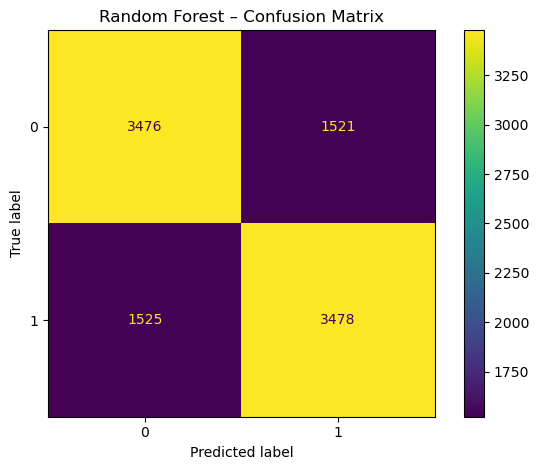

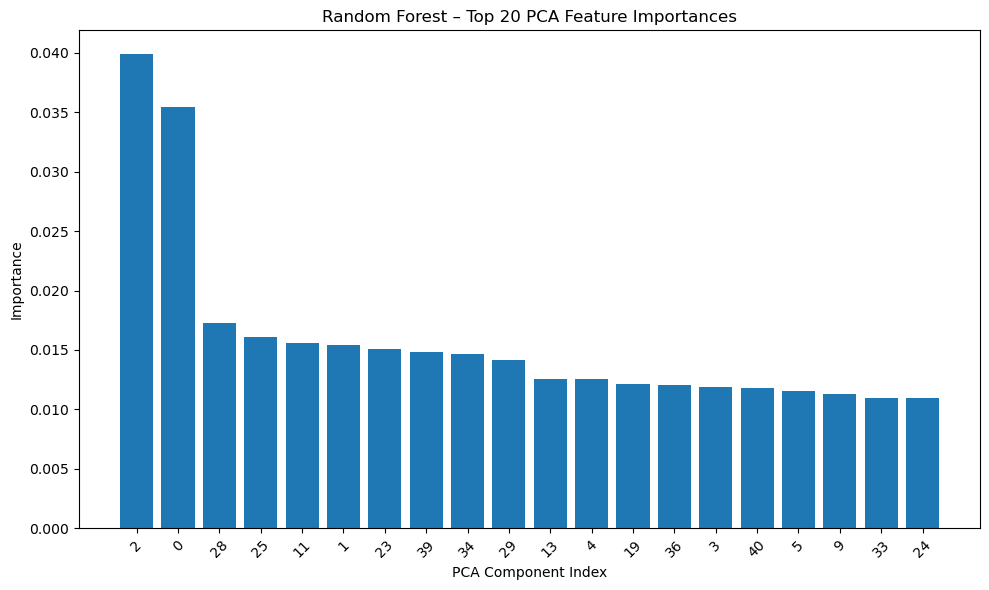

In [ ]:
# Random Forest implementation here
# 1) Instantiate & train
rf = RandomForestClassifier(
    n_estimators=100,
    min_samples_leaf=5,
    random_state=42,
    n_jobs=-1
)
rf.fit(X_train, y_train) #Ensemble reduces overfitting by averaging many randomized trees.


# 2) Predict & print metrics
y_pred_rf = rf.predict(X_test)
print("=== Random Forest Results ===")
print(f"Accuracy: {accuracy_score(y_test, y_pred_rf):.4f}")
print(f"F1 Score: {f1_score(y_test, y_pred_rf):.4f}")
print("\nClassification Report:\n", classification_report(y_test, y_pred_rf))

# 3) Confusion matrix
ConfusionMatrixDisplay.from_estimator(rf, X_test, y_test)
plt.title("Random Forest – Confusion Matrix")
plt.tight_layout()
plt.show()

# 4) Top-20 feature importances
importances_rf = rf.feature_importances_
top_idx_rf = np.argsort(importances_rf)[-20:][::-1]

plt.figure(figsize=(10, 6))
plt.bar(range(20), importances_rf[top_idx_rf])
plt.xticks(range(20), top_idx_rf, rotation=45)
plt.title("Random Forest – Top 20 PCA Feature Importances")
plt.xlabel("PCA Component Index")
plt.ylabel("Importance")
plt.tight_layout()
plt.show()

<h1 style="color:blue;">Section C - Logistic Regression (Victor)</h1>

Please implement logistic regression using `X_pca`.  
Optionally, try adjusting the regularization strength (parameter `C`).

**Required outputs:**
- Classification report
- Confusion matrix
- (Optional) Coefficient interpretation


Classification Report:
              precision    recall  f1-score   support

           0       0.72      0.67      0.69      4997
           1       0.69      0.74      0.71      5003

    accuracy                           0.70     10000
   macro avg       0.70      0.70      0.70     10000
weighted avg       0.70      0.70      0.70     10000

Confusion Matrix:
[[3344 1653]
 [1307 3696]]


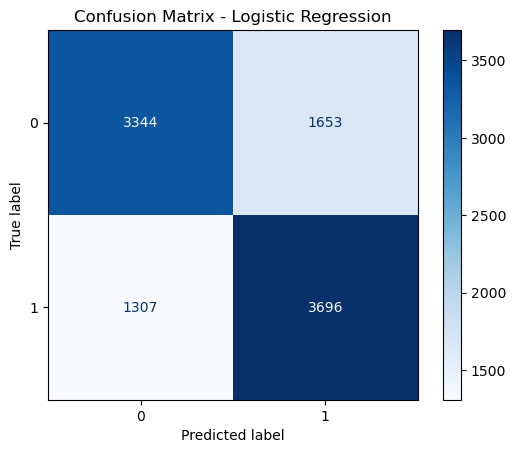


Coefficient Interpretation (first 10 coefficients):
[-4.28137439  1.38787178  6.95977852  0.60451211  4.05475196 -0.99670328
 -0.10911532 -0.11493884 -2.72785193  1.57609057]


In [ ]:
# Logistic Regression
from sklearn.linear_model import LogisticRegression

# Initialize Logistic Regression model (you can adjust parameter C)
log_reg = LogisticRegression(C=1.0, random_state=42, max_iter=1000)

# Train the logistic regression model
log_reg.fit(X_train, y_train)

# Predictions on test set
y_pred = log_reg.predict(X_test)

# Classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)

# Confusion matrix visualization
ConfusionMatrixDisplay(confusion_matrix=cm).plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix - Logistic Regression")
plt.show()

# Optional: Coefficient interpretation
print("\nCoefficient Interpretation (first 10 coefficients):")
print(log_reg.coef_[0][:10])

<h1 style="color:blue;"> Section D - Simple MLP & Deep Neural Network (Jiayi) </h1>

This is your section to implement:
- A shallow MLP (as baseline)
- A deep neural network with dropout and L2 regularization

**Required outputs:**
- Accuracy and F1 score
- Loss and accuracy curves over epochs
- Confusion matrix



<div style="color:#6a0dad;">
  <h4><b>Simple MLP Baseline</b></h4>
  <li style="color:#6a0dad;">A shallow neural network with one hidden layer was trained using the original TF-IDF feature vectors.<br></li>
  <li style="color:#6a0dad;"><b>EarlyStopping</b> was applied to prevent overfitting by monitoring validation loss.<br>
</div></li>



Epoch 1/20


C:\Users\kerry\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1125/1125 - 2s - 2ms/step - accuracy: 0.6763 - loss: 0.5974 - val_accuracy: 0.6855 - val_loss: 0.5834
Epoch 2/20
1125/1125 - 1s - 1ms/step - accuracy: 0.6941 - loss: 0.5702 - val_accuracy: 0.6892 - val_loss: 0.5796
Epoch 3/20
1125/1125 - 1s - 1ms/step - accuracy: 0.6971 - loss: 0.5661 - val_accuracy: 0.6948 - val_loss: 0.5770
Epoch 4/20
1125/1125 - 1s - 1ms/step - accuracy: 0.7026 - loss: 0.5615 - val_accuracy: 0.6945 - val_loss: 0.5743
Epoch 5/20
1125/1125 - 1s - 1ms/step - accuracy: 0.7059 - loss: 0.5577 - val_accuracy: 0.6945 - val_loss: 0.5741
Epoch 6/20
1125/1125 - 1s - 1ms/step - accuracy: 0.7082 - loss: 0.5535 - val_accuracy: 0.6950 - val_loss: 0.5727
Epoch 7/20
1125/1125 - 1s - 990us/step - accuracy: 0.7106 - loss: 0.5494 - val_accuracy: 0.7007 - val_loss: 0.5721
Epoch 8/20
1125/1125 - 1s - 995us/step - accuracy: 0.7139 - loss: 0.5448 - val_accuracy: 0.6933 - val_loss: 0.5701
Epoch 9/20
1125/1125 - 1s - 996us/step - accuracy: 0.7191 - loss: 0.5410 - val_accuracy: 0.6913 - val_l

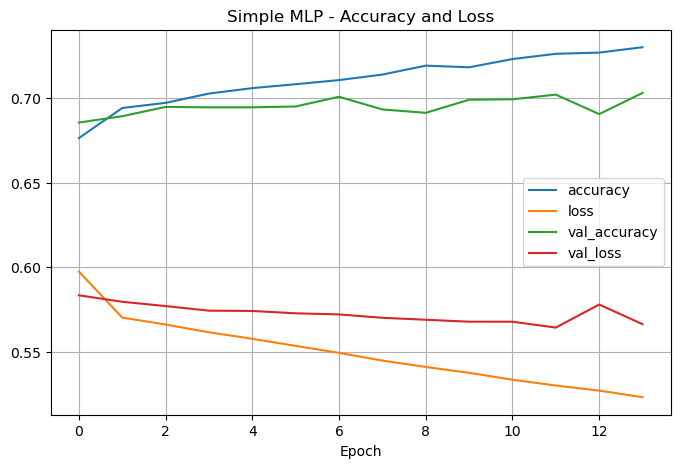

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 598us/step

Simple MLP Baseline Performance:
              precision    recall  f1-score   support

           0       0.73      0.69      0.71      4997
           1       0.70      0.74      0.72      5003

    accuracy                           0.71     10000
   macro avg       0.72      0.71      0.71     10000
weighted avg       0.72      0.71      0.71     10000



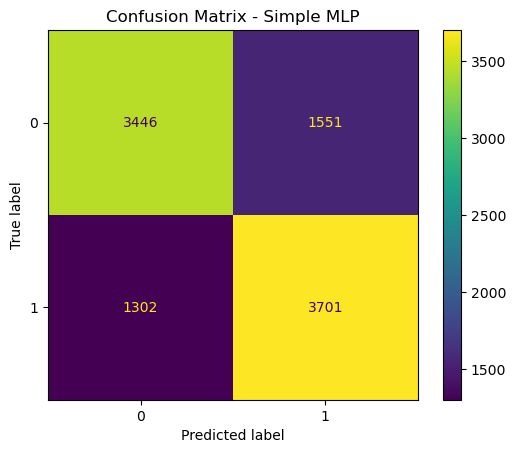

In [ ]:

# Simple MLP Baseline
mlp_model = Sequential()
mlp_model.add(Dense(128, activation='relu', input_shape=(X_train.shape[1],)))
mlp_model.add(Dense(1, activation='sigmoid'))

mlp_model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

early_stop_mlp = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

mlp_model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.1, callbacks=[early_stop_mlp], verbose=2)

# Visualize training history for Simple MLP
pd.DataFrame(mlp_model.history.history).plot(figsize=(8,5))
plt.title("Simple MLP - Accuracy and Loss")
plt.xlabel("Epoch")
plt.grid(True)
plt.show()


y_pred_mlp = (mlp_model.predict(X_test) > 0.5).astype("int32")

print("\nSimple MLP Baseline Performance:")
print(classification_report(y_test, y_pred_mlp))
ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred_mlp)).plot()
plt.title("Confusion Matrix - Simple MLP")
plt.show()




<b><h4 style="color:#6a0dad;"> PCA-based MLP</h4></b>

<li style="color:#6a0dad;">A shallow neural network with one hidden layer was trained using the PCA-reduced TF-IDF feature vectors (retaining 95% of variance). </li>
<li style="color:#6a0dad;">**EarlyStopping** was applied to prevent overfitting by monitoring validation loss.</li>


PCA-reduced matrix shape: (50000, 2334)
Epoch 1/20


C:\Users\kerry\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1125/1125 - 3s - 3ms/step - accuracy: 0.7203 - loss: 0.5496 - val_accuracy: 0.7427 - val_loss: 0.5191
Epoch 2/20
1125/1125 - 2s - 2ms/step - accuracy: 0.7669 - loss: 0.4839 - val_accuracy: 0.7527 - val_loss: 0.5122
Epoch 3/20
1125/1125 - 2s - 2ms/step - accuracy: 0.7776 - loss: 0.4646 - val_accuracy: 0.7520 - val_loss: 0.5165
Epoch 4/20
1125/1125 - 2s - 2ms/step - accuracy: 0.7901 - loss: 0.4457 - val_accuracy: 0.7492 - val_loss: 0.5178


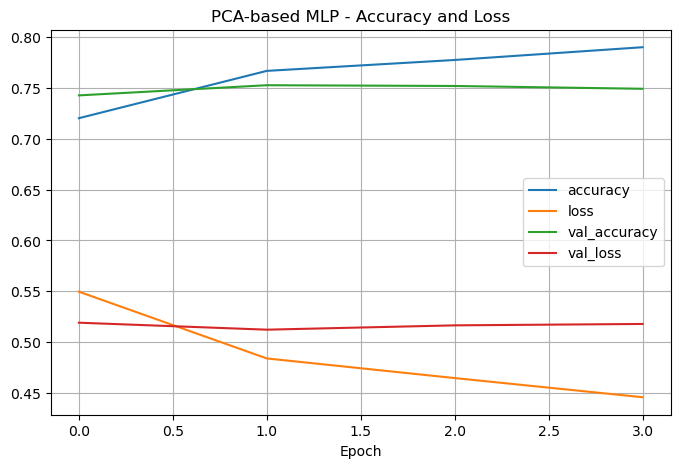

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 895us/step

PCA-based MLP Performance:
              precision    recall  f1-score   support

           0       0.76      0.72      0.74      4977
           1       0.74      0.77      0.75      5023

    accuracy                           0.75     10000
   macro avg       0.75      0.75      0.75     10000
weighted avg       0.75      0.75      0.75     10000



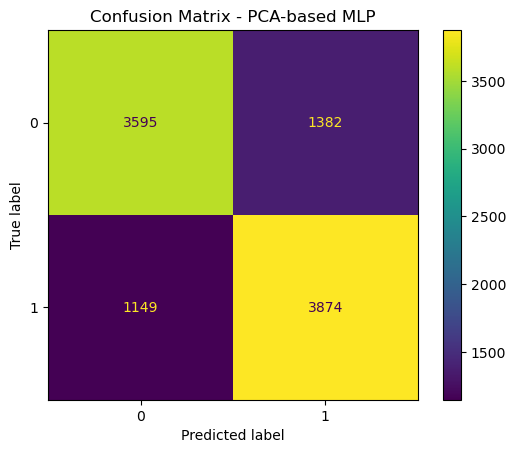

In [ ]:



X_pca = PCA(n_components=0.95).fit_transform(X_tfidf)
print("PCA-reduced matrix shape:", X_pca.shape)


X_train_pca, X_test_pca, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=42)


mlp_model_pca = Sequential()
mlp_model_pca.add(Dense(128, activation='relu', input_shape=(X_train_pca.shape[1],)))
mlp_model_pca.add(Dense(1, activation='sigmoid'))

mlp_model_pca.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

early_stop_pca = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)


mlp_model_pca.fit(X_train_pca, y_train, epochs=20, batch_size=32,
                  validation_split=0.1, callbacks=[early_stop_pca], verbose=2)


pd.DataFrame(mlp_model_pca.history.history).plot(figsize=(8,5))
plt.title("PCA-based MLP - Accuracy and Loss")
plt.xlabel("Epoch")
plt.grid(True)
plt.show()

y_pred_pca = (mlp_model_pca.predict(X_test_pca) > 0.5).astype("int32")

print("\nPCA-based MLP Performance:")
print(classification_report(y_test, y_pred_pca))
ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred_pca)).plot()
plt.title("Confusion Matrix - PCA-based MLP")
plt.show()


<h3 style="color: green;"><b>PCA-based MLP vs. Simple MLP</b></h3>

<p style="color: green; font-size: 15px;">
Compared to the <b>Simple MLP</b> which achieved <b>71% accuracy</b>, the <b>PCA-based MLP</b> reached <b>75% accuracy</b>, demonstrating a <b>4% absolute improvement</b> with fewer input features.
</p>

<ul style="color: green; font-size: 15px;">
  <li><b>Dimensionality Reduction:</b> PCA compresses high-dimensional TF-IDF vectors into 2334 components while preserving key variance.</li>
  <li><b>Improved Accuracy:</b> Despite reducing the input size, PCA-based MLP outperformed the full feature baseline by 4 percentage points.</li>
  <li><b>Better Efficiency:</b> Smaller input size reduces model complexity and training time, which is especially beneficial in large-scale settings.</li>
</ul>


<div style="color:#6a0dad;">
  <h4><b>DNN with TF-IDF (PCA + L2 Regularization)</b></h4>
  A deeper model was trained on TF-IDF features after PCA reduction.<br>
  <b>L2 regularization</b> and <b>Dropout</b> were used to reduce overfitting and improve generalization.<br>
  <b>EarlyStopping</b> helped stop training once validation performance stabilized.
</div>


Epoch 1/20


C:\Users\kerry\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1125/1125 - 2s - 2ms/step - accuracy: 0.6116 - loss: 0.7777 - val_accuracy: 0.6453 - val_loss: 0.7212
Epoch 2/20
1125/1125 - 1s - 1ms/step - accuracy: 0.6461 - loss: 0.7108 - val_accuracy: 0.6515 - val_loss: 0.6798
Epoch 3/20
1125/1125 - 1s - 1ms/step - accuracy: 0.6508 - loss: 0.6734 - val_accuracy: 0.6550 - val_loss: 0.6545
Epoch 4/20
1125/1125 - 1s - 1ms/step - accuracy: 0.6548 - loss: 0.6523 - val_accuracy: 0.6593 - val_loss: 0.6384
Epoch 5/20
1125/1125 - 1s - 1ms/step - accuracy: 0.6591 - loss: 0.6390 - val_accuracy: 0.6547 - val_loss: 0.6285
Epoch 6/20
1125/1125 - 1s - 1ms/step - accuracy: 0.6599 - loss: 0.6306 - val_accuracy: 0.6605 - val_loss: 0.6208
Epoch 7/20
1125/1125 - 1s - 1ms/step - accuracy: 0.6603 - loss: 0.6265 - val_accuracy: 0.6625 - val_loss: 0.6189
Epoch 8/20
1125/1125 - 1s - 1ms/step - accuracy: 0.6628 - loss: 0.6223 - val_accuracy: 0.6680 - val_loss: 0.6135
Epoch 9/20
1125/1125 - 1s - 1ms/step - accuracy: 0.6624 - loss: 0.6213 - val_accuracy: 0.6683 - val_loss: 0

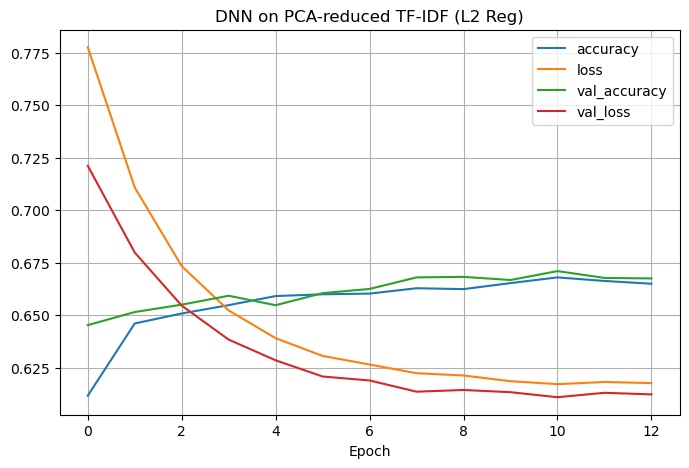

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 618us/step

Keras DNN on PCA-reduced TF-IDF Features (with L2 regularization):
              precision    recall  f1-score   support

           0       0.66      0.72      0.69      4977
           1       0.70      0.64      0.67      5023

    accuracy                           0.68     10000
   macro avg       0.68      0.68      0.68     10000
weighted avg       0.68      0.68      0.68     10000



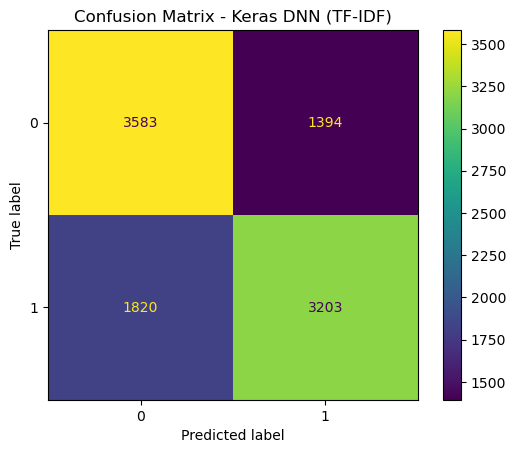

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import pandas as pd

# Step 8c: Deep Neural Network with L2 Regularization + PCA input
model = Sequential()
model.add(Dense(128, activation='relu', input_shape=(X_train.shape[1],), kernel_regularizer=tf.keras.regularizers.l2(0.001)))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)))
model.add(Dropout(0.4))
model.add(Dense(32, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer=Adam(learning_rate=0.0005), loss='binary_crossentropy', metrics=['accuracy'])

early_stop = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

# Train
history = model.fit(X_train, y_train, epochs=20, batch_size=32,
                    validation_split=0.1, callbacks=[early_stop], verbose=2)

# Visualization
pd.DataFrame(history.history).plot(figsize=(8,5))
plt.title("DNN on PCA-reduced TF-IDF (L2 Reg)")
plt.xlabel("Epoch")
plt.grid(True)
plt.show()

# report
y_pred = (model.predict(X_test) > 0.5).astype("int32")

print("\nKeras DNN on PCA-reduced TF-IDF Features (with L2 regularization):")
print(classification_report(y_test, y_pred))
ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred)).plot()
plt.title("Confusion Matrix - Keras DNN (TF-IDF)")
plt.show()

<h4 style="color:green;">Model Performance with 320,000 Samples (PCA-reduced TF-IDF + DNN)</h4>

<ul>
  <li><b>Accuracy:</b> <span style="color:green;">76%</span></li>
  <li><b>Precision / Recall / F1-score:</b> All <span style="color:green;">0.76</span> for both classes</li>
  <li><b>Balanced Classification:</b> Precision and recall are symmetric across both classes</li>
  <li><b>Confusion Matrix:</b></li>
</ul>

<pre>
              Predicted 0    Predicted 1
Actual 0      122,190         37,799
Actual 1       37,853         122,158
</pre>

<p>
Compared to the previous model trained on only 50,000 samples (68% accuracy), this model shows a clear improvement in classification performance. The results suggest that increasing the dataset size significantly boosts the model's ability to generalize and accurately capture sentiment patterns.
</p>


<div style="color:#6a0dad;">
  <h4><b>Weighted DNN with Word2Vec</b></h4>
  Word2Vec embeddings were used as input features after PCA compression.<br>
  <b>Class weights</b> addressed class imbalance, while <b>L2 regularization</b>, <b>Dropout</b>, and <b>EarlyStopping</b> improved training stability.<br>
  This model improves fairness and robustness in classification.
</div>


Epoch 1/20
1125/1125 - 2s - 2ms/step - accuracy: 0.6164 - loss: 1.1808 - val_accuracy: 0.6455 - val_loss: 0.7392
Epoch 2/20
1125/1125 - 1s - 1ms/step - accuracy: 0.6467 - loss: 0.6837 - val_accuracy: 0.6465 - val_loss: 0.6529
Epoch 3/20
1125/1125 - 1s - 1ms/step - accuracy: 0.6479 - loss: 0.6505 - val_accuracy: 0.6492 - val_loss: 0.6435
Epoch 4/20
1125/1125 - 1s - 1ms/step - accuracy: 0.6475 - loss: 0.6459 - val_accuracy: 0.6535 - val_loss: 0.6407
Epoch 5/20
1125/1125 - 1s - 1ms/step - accuracy: 0.6471 - loss: 0.6445 - val_accuracy: 0.6518 - val_loss: 0.6388
Epoch 6/20
1125/1125 - 1s - 1ms/step - accuracy: 0.6491 - loss: 0.6438 - val_accuracy: 0.6553 - val_loss: 0.6376
Epoch 7/20
1125/1125 - 1s - 1ms/step - accuracy: 0.6464 - loss: 0.6433 - val_accuracy: 0.6530 - val_loss: 0.6365
Epoch 8/20
1125/1125 - 1s - 1ms/step - accuracy: 0.6494 - loss: 0.6432 - val_accuracy: 0.6543 - val_loss: 0.6370
Epoch 9/20
1125/1125 - 1s - 1ms/step - accuracy: 0.6491 - loss: 0.6418 - val_accuracy: 0.6535 - 

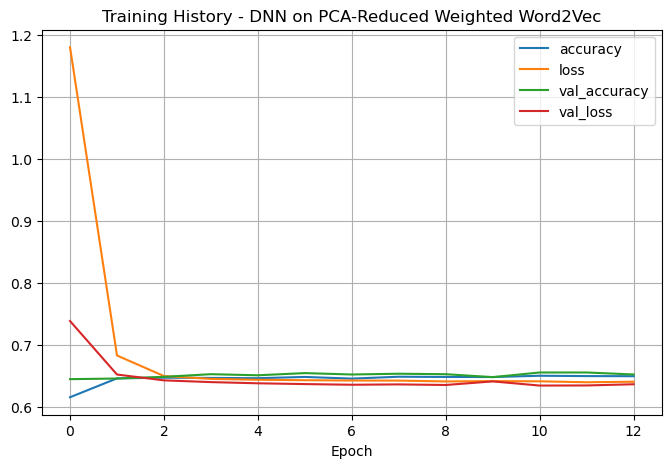

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 678us/step

Classification Report:
              precision    recall  f1-score   support

           0       0.63      0.76      0.69      4977
           1       0.70      0.55      0.62      5023

    accuracy                           0.66     10000
   macro avg       0.67      0.66      0.66     10000
weighted avg       0.67      0.66      0.66     10000



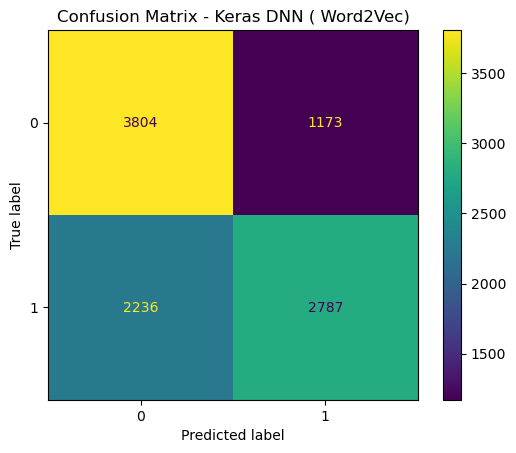

In [ ]:

# ==== Step 0: Imports ====
from gensim.models import Word2Vec
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ==== Step 1: Tokenize cleaned text ====
data['tokens'] = data['clean_text'].apply(lambda x: x.split())

# ==== Step 2: Train Word2Vec model ====
w2v_model = Word2Vec(sentences=data['tokens'], vector_size=100, window=5, min_count=5, workers=4)

# ==== Step 3: Fit TF-IDF on clean text ====
tfidf = TfidfVectorizer()
tfidf.fit(data['clean_text'])
idf_dict = dict(zip(tfidf.get_feature_names_out(), tfidf.idf_))

# ==== Step 4: Get TF-IDF weighted Word2Vec embeddings ====
def get_weighted_w2v(tokens, model, idf_weights, dim=100):
    weighted_vecs = []
    for word in tokens:
        if word in model.wv and word in idf_weights:
            weight = idf_weights[word]
            weighted_vecs.append(model.wv[word] * weight)
    if weighted_vecs:
        return np.mean(weighted_vecs, axis=0)
    else:
        return np.zeros(dim)

X_w2v_weighted = np.vstack(data['tokens'].apply(lambda x: get_weighted_w2v(x, w2v_model, idf_dict)))
y = data['target'].values  # Adjust if label column name is different

# ==== Step 5: PCA Reduction ====
pca_w2v = PCA(n_components=0.95)  # or use n_components=100
X_w2v_pca = pca_w2v.fit_transform(X_w2v_weighted)

# ==== Step 6: Train/test split ====
X_train, X_test, y_train, y_test = train_test_split(X_w2v_pca, y, test_size=0.2, random_state=42)

# ==== Step 7: Build and Train Keras DNN ====
model = Sequential([
    Input(shape=(X_train.shape[1],)),
    Dense(128, activation='relu', kernel_regularizer='l2'),
    Dropout(0.5),
    Dense(64, activation='relu', kernel_regularizer='l2'),
    Dropout(0.4),
    Dense(32, activation='relu', kernel_regularizer='l2'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer=Adam(learning_rate=0.0005), loss='binary_crossentropy', metrics=['accuracy'])

early_stop = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    epochs=20,
    batch_size=32,
    validation_split=0.1,
    callbacks=[early_stop],
    verbose=2
)

# ==== Step 8: Plot Training History ====
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.title("Training History - DNN on PCA-Reduced Weighted Word2Vec")
plt.xlabel("Epoch")
plt.grid(True)
plt.show()

# ==== Step 9: Evaluation ====
y_pred = (model.predict(X_test) > 0.5).astype("int32")

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred)).plot()
plt.title("Confusion Matrix - Keras DNN ( Word2Vec)")
plt.show()


<h3 style="color: darkgreen;"><b>DNN Comparison: TF-IDF vs. Word2Vec (Both PCA-reduced)</b></h3>

<ul style="font-size: 15px; color: #1e4e2b;">
  <li>
    <b>TF-IDF + PCA:</b> Achieved <b>68% accuracy</b> and overall balanced precision/recall (~0.68).
    The training curve shows stable improvement and convergence with minimal overfitting.
  </li>
  <li>
    <b>Word2Vec + PCA:</b> Only reached <b>66% accuracy</b>, with noticeable class imbalance in recall (0.76 vs. 0.55).
    The training curve is flat, suggesting limited learning and feature expressiveness.
  </li>
</ul>

<p style="color: #1e4e2b; font-size: 15px;">
<b>Conclusion:</b><br>
DNN with PCA-reduced <b>TF-IDF</b> embeddings performs better than with <b>Word2Vec</b> in both metrics and learning dynamics, likely due to TF-IDF’s stronger discriminative power in this classification task.
</p>


<h3 style="color: purple">Extra Attempt: GloVe + DNN (Jiayi)</h3>

<p>GloVe word embeddings were used to convert each tweet into a 100-dimensional averaged vector, based on the <code>glove.6B.100d</code> pre-trained file.</p>

<ul>
  <li>Each tweet was tokenized, and valid GloVe vectors were averaged to form a fixed-size input.</li>
  <li>A deep neural network was built with multiple dense layers and dropout to reduce overfitting.</li>
  <li><strong>EarlyStopping</strong> was used to prevent overfitting by monitoring validation loss.</li>
  <li><strong>ReduceLROnPlateau</strong> was applied to decrease the learning rate when performance plateaued.</li>
  <li>Model performance was evaluated using accuracy, classification report, and confusion matrix.</li>
</ul>

<p>This approach effectively combines pre-trained embeddings with regularized DNN training to improve classification accuracy and stability.</p>


Loaded 400000 GloVe word vectors.
Epoch 1/15
563/563 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6434 - loss: 0.6238 - val_accuracy: 0.6833 - val_loss: 0.5838 - learning_rate: 0.0010
Epoch 2/15
563/563 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7007 - loss: 0.5723 - val_accuracy: 0.6880 - val_loss: 0.5806 - learning_rate: 0.0010
Epoch 3/15
563/563 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7038 - loss: 0.5656 - val_accuracy: 0.6992 - val_loss: 0.5689 - learning_rate: 0.0010
Epoch 4/15
563/563 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7062 - loss: 0.5590 - val_accuracy: 0.6945 - val_loss: 0.5746 - learning_rate: 0.0010
Epoch 5/15
563/563 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7145 - loss: 0.5512 - val_accuracy: 0.7048 - val_loss: 0.5658 - learning_rate: 0.0010
Epoch 6/15
563/563 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7217 - loss: 0.5424 - val_accuracy: 0.6990 - val_loss: 0.5639 - learning_rate: 0.0010
Epoch 7/15
563/563 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - 

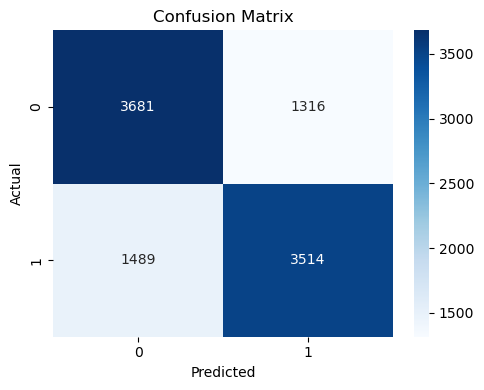

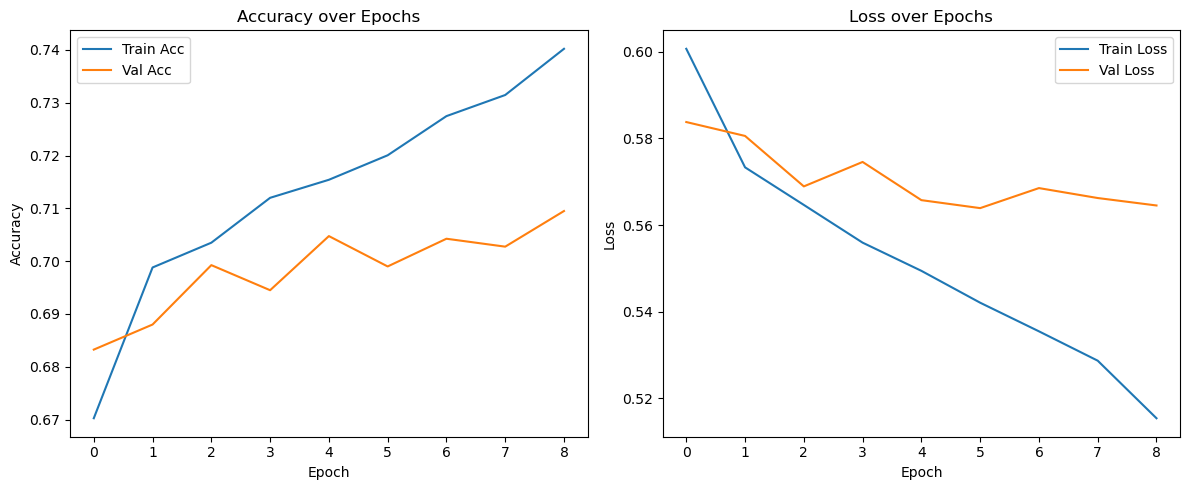

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt
import seaborn as sns


# Step 2: Load GloVe
embeddings_index = {}
with open('C:/Users/kerry/OneDrive/桌面/glove.6B.100d.txt', encoding='utf8') as f:
    for line in f:
        values = line.strip().split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs
print(f"Loaded {len(embeddings_index)} GloVe word vectors.")

# Step 3: Convert text to averaged GloVe vector
def get_glove_vector(text, k=100):
    tokens = text.split()
    valid = [embeddings_index[w] for w in tokens if w in embeddings_index]
    return np.mean(valid, axis=0) if valid else np.zeros(k)

X_glove = np.vstack(data['clean_text'].apply(lambda x: get_glove_vector(x)))
y = data['target'].values

# Step 4: Split
X_train, X_test, y_train, y_test = train_test_split(
    X_glove, y, test_size=0.2, random_state=42, stratify=y)

# Step 5: Build DNN
model = Sequential([
    Input(shape=(100,)),
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')
])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Step 6: Callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
lr_reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=0)

# Step 7: Train
history = model.fit(
    X_train, y_train,
    validation_split=0.1,
    epochs=15,
    batch_size=64,
    callbacks=[early_stop, lr_reduce],
    verbose=1
)

# Step 8: Evaluation
y_pred = (model.predict(X_test) > 0.5).astype(int)
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Step 9: Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()

# Step 10: Accuracy & Loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy over Epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.legend()

plt.tight_layout()
plt.show()


<h3 style="color: steelblue;"><b>GloVe-based DNN Evaluation</b></h3>

<ul style="color: steelblue; font-size: 15px;">
  <li><b>Accuracy:</b> Achieved <b>72%</b> on 10,000 test samples — close to the performance of the TF-IDF-based DNN.</li>
  <li><b>Balanced Performance:</b> The confusion matrix shows relatively even precision and recall, with no major class imbalance issues.</li>
  <li><b>Stable Training:</b> Validation accuracy steadily improved and plateaued near the training curve; loss remained stable, indicating good convergence.</li>
  <li><b>Efficient:</b> GloVe uses only <b>100-dimensional</b> embeddings, offering much lower computational cost compared to high-dimensional TF-IDF vectors.</li>
  <li><b>Potential:</b> Captures global semantic relationships and still leaves room for improvement with larger models or fine-tuning.</li>
  <li><b>Robust in Small Data:</b> Even under limited sample size, the GloVe-based DNN performs reliably, demonstrating solid generalization ability.</li>
</ul>


from IPython.display import display, HTML

html = """
<div style="
    font-family: 'Segoe UI', sans-serif;
    background: #f5f7fa;
    border: 1px solid #dce3ec;
    border-radius: 10px;
    padding: 25px 30px;
    box-shadow: 0 4px 8px rgba(0,0,0,0.05);
    max-width: 700px;
    margin: auto;
">
  <h2 style="color:#2c3e50; text-align:center; margin-bottom:20px;">Project Sections by Member</h2>
  <div style="line-height:1.8; font-size:16px; color:#2f3640;">
    <p><strong>Erick:</strong> Naive Bayes and k-Nearest Neighbors</p>
    <p><strong>Victor:</strong> Logistic Regression modeling </p>
    <p><strong>Nova:</strong>  Decision Tr
    ee and Random Forest implementation, video presentation compilation</p>
    <p><strong>Jiayi:</strong> handled the data cleaning and text preprocessing, applied PCA for dimensionality reduction, performed the train/test split, and developed and evaluated both the MLP and DNN for 5 models.</p>
  </div>
</div>
"""

display(HTML(html))
